In [125]:
import numpy as np
from scipy.optimize import root
import matplotlib.pyplot as plt

class MutualExcitationNetwork:
    def __init__(self, w1=0.4, w2=0.4, I=-10):
        """
        Initialize the 2D network with mutual excitation.
        
        Parameters:
        - w1: Synaptic strength from x to y
        - w2: Synaptic strength from y to x
        - I: External input to both neurons
        """
        self.w1 = w1          # Synaptic strength from x to y
        self.w2 = w2          # Synaptic strength from y to x
        self.I = I            # External input
        
        # Default parameters for various analyses
        self.default_params = {
            'x_range': (0, 50),
            'y_range': (0, 50),
            'I_range': (-20, -10),
            'w_range': (0, 1),
            'dt': 0.1,
            't_max': 20
        }
        
    #--------------------- Core Functions ---------------------#
    
    def activation_function(self, s):
        """Sigmoid activation function: f(s) = 50 * σ(s) = 50 / (1 + e^(-s))"""
        return 50 / (1 + np.exp(-s))
    
    def activation_derivative(self, s):
        """Derivative of sigmoid function: σ'(s) = σ(s)(1 - σ(s))"""
        sigma = 1 / (1 + np.exp(-s))
        return 50 * sigma * (1 - sigma)
    
    def derivatives(self, state):
        """Calculate dx/dt and dy/dt for the network"""
        x, y = state
        
        # Calculate total inputs
        input_to_x = self.w2 * y + self.I
        input_to_y = self.w1 * x + self.I
        
        # Calculate derivatives
        dx_dt = -x + self.activation_function(input_to_x)
        dy_dt = -y + self.activation_function(input_to_y)
        
        return np.array([dx_dt, dy_dt])
    
    #--------------------- Simulation Methods ---------------------#
    
    def simulate(self, initial_state, t_max=None, dt=None):
        """
        Simulate the network dynamics
        
        Parameters:
        - initial_state: Initial values [x0, y0]
        - t_max: Maximum simulation time
        - dt: Time step
        
        Returns:
        - t: Time points
        - state: Array of [x, y] values over time
        """
        t_max = t_max if t_max is not None else self.default_params['t_max']
        dt = dt if dt is not None else self.default_params['dt']
        
        steps = int(t_max / dt)
        t = np.linspace(0, t_max, steps)
        state = np.zeros((steps, 2))
        state[0] = initial_state
        
        for i in range(1, steps):
            derivatives = self.derivatives(state[i-1])
            state[i] = state[i-1] + derivatives * dt
            
        return t, state
    
    def simulate_multiple(self, initial_states, t_max=None, dt=None):
        """Simulate the network dynamics for multiple initial conditions"""
        t_max = t_max if t_max is not None else self.default_params['t_max']
        dt = dt if dt is not None else self.default_params['dt']
        
        results = []
        for init_state in initial_states:
            t, state = self.simulate(init_state, t_max, dt)
            results.append((t, state))
        return results
    
    #--------------------- Plotting Methods ---------------------#
    
    def plot_dynamics(self, initial_states, t_max=None, dt=None):
        """Plot the time evolution of x(t) and y(t) for different initial conditions"""
        t_max = t_max if t_max is not None else self.default_params['t_max']
        dt = dt if dt is not None else self.default_params['dt']
        
        results = self.simulate_multiple(initial_states, t_max, dt)
        
        # Create two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
        
        for i, (t, state) in enumerate(results):
            x = state[:, 0]
            y = state[:, 1]
            
            label = f"Initial: ({initial_states[i][0]}, {initial_states[i][1]})"
            ax1.plot(t, x, label=label)
            ax2.plot(t, y, label=label)
        
        ax1.set_ylabel('Neuron x firing rate')
        ax1.set_title('Time evolution of neuron x')
        ax1.grid(True)
        ax1.legend()
        
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Neuron y firing rate')
        ax2.set_title('Time evolution of neuron y')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('./latex/dynamics2_plot.png')
        plt.show()
    
    def plot_state_space(self, initial_states, t_max=None, dt=None, show_nullclines=False, 
                       show_fixed_points=False, quiver=False):
        """Plot trajectories in state space (x vs y)"""
        t_max = t_max if t_max is not None else self.default_params['t_max']
        dt = dt if dt is not None else self.default_params['dt']
        
        results = self.simulate_multiple(initial_states, t_max, dt)
        
        plt.figure(figsize=(10, 8))
        
        # Plot trajectories
        for i, (t, state) in enumerate(results):
            x = state[:, 0]
            y = state[:, 1]
            
            # Plot trajectory
            plt.plot(x, y, label=f"Initial: ({initial_states[i][0]}, {initial_states[i][1]})", alpha=0.7)
            
            # Add arrow to show direction
            arrow_idx = min(len(x) - 10, max(10, len(x) // 5))
            plt.arrow(x[arrow_idx], y[arrow_idx], 
                      x[arrow_idx+1] - x[arrow_idx], 
                      y[arrow_idx+1] - y[arrow_idx],
                      head_width=1, head_length=1, fc='k', ec='k')
        
        # Show nullclines if requested
        if show_nullclines:
            self.add_nullclines_to_plot()
        
        # Show fixed points if requested
        if show_fixed_points:
            fixed_points = self.find_fixed_points()
            if fixed_points:
                fps = np.array(fixed_points)
                plt.scatter(fps[:, 0], fps[:, 1], color='red', s=100, 
                           zorder=5, label='Fixed Points')
        
        # Add vector field (quiver plot) if requested
        if quiver:
            self.add_vector_field_to_plot()
        
        plt.xlabel('Neuron x firing rate')
        plt.ylabel('Neuron y firing rate')
        plt.title('State Space: x vs y')
        plt.grid(True)
        plt.legend()

        if show_fixed_points:
            plt.savefig('./latex/state_space2_fixed_points.png')
        elif show_nullclines:
            plt.savefig('./latex/state_space2_nullclines.png')
        else:
            plt.savefig('./latex/state_space2.png')
        plt.show()
    
    #--------------------- Nullcline Methods ---------------------#
    
    def x_nullcline(self, y_range=None):
        """Calculate x-nullcline points where dx/dt = 0"""
        y_range = y_range if y_range is not None else self.default_params['y_range']
        y_values = np.linspace(y_range[0], y_range[1], 1000)
        
        # For x-nullcline: x = f(w2*y + I)
        x_values = self.activation_function(self.w2 * y_values + self.I)
        
        return y_values, x_values
    
    def y_nullcline(self, x_range=None):
        """Calculate y-nullcline points where dy/dt = 0"""
        x_range = x_range if x_range is not None else self.default_params['x_range']
        x_values = np.linspace(x_range[0], x_range[1], 1000)
        
        # For y-nullcline: y = f(w1*x + I)
        y_values = self.activation_function(self.w1 * x_values + self.I)
        
        return x_values, y_values
    
    def add_nullclines_to_plot(self, x_range=None, y_range=None):
        """Add nullclines to the current plot"""
        x_range = x_range if x_range is not None else self.default_params['x_range']
        y_range = y_range if y_range is not None else self.default_params['y_range']
        
        # Get nullclines
        y_vals, x_vals = self.x_nullcline(y_range)
        x_vals_y, y_vals_y = self.y_nullcline(x_range)
        
        # Plot nullclines
        plt.plot(x_vals, y_vals, 'r--', label='x-nullcline: dx/dt = 0')
        plt.plot(x_vals_y, y_vals_y, 'b--', label='y-nullcline: dy/dt = 0')
    
    def add_vector_field_to_plot(self, density=20, scale=10):
        """Add vector field to the current plot"""
        # Create grid
        x = np.linspace(0, 50, density)
        y = np.linspace(0, 50, density)
        X, Y = np.meshgrid(x, y)
        
        # Calculate derivatives at each point
        U = np.zeros_like(X)
        V = np.zeros_like(Y)
        
        for i in range(density):
            for j in range(density):
                derivatives = self.derivatives([X[i, j], Y[i, j]])
                U[i, j] = derivatives[0]
                V[i, j] = derivatives[1]
        
        # Normalize
        magnitude = np.sqrt(U**2 + V**2)
        U = U / (magnitude + 1e-10) * scale  # Avoid division by zero
        V = V / (magnitude + 1e-10) * scale
        
        plt.quiver(X, Y, U, V, alpha=0.3, color='gray')
    
    def plot_nullclines(self, x_range=None, y_range=None):
        """Plot nullclines of the system"""
        x_range = x_range if x_range is not None else self.default_params['x_range']
        y_range = y_range if y_range is not None else self.default_params['y_range']
        
        plt.figure(figsize=(10, 8))
        
        self.add_nullclines_to_plot(x_range, y_range)
        
        plt.xlabel('Neuron x firing rate')
        plt.ylabel('Neuron y firing rate')
        plt.title('Nullclines of the 2D Network')
        plt.grid(True)
        plt.legend()
        plt.show()
    
    #--------------------- Fixed Point Analysis ---------------------#
    
    def find_fixed_points(self):
        """Find fixed points by locating the intersections of nullclines"""
        
        # Define fixed point equations (where dx/dt = 0 and dy/dt = 0)
        def fixed_point_equations(xy):
            x, y = xy
            dx_dt = -x + self.activation_function(self.w2 * y + self.I)
            dy_dt = -y + self.activation_function(self.w1 * x + self.I)
            return [dx_dt, dy_dt]
        
        # Generate strategic initial guesses for different types of fixed points
        fixed_points = []
        key_guesses = [
            [0, 0],      # Low-low state
            [50, 50],    # High-high state
            [25, 25],    # Middle state (often a saddle)
            [10, 40],    # Mixed state (low-high)
            [40, 10],     # Mixed state (high-low)
            [20, 30],    # Another mixed state
            [30, 20],    # Another mixed state
            [5, 45],     # Low-high state
            [45, 5],     # High-low state
            [10, 10],    # Low state
            [40, 40],    # High state
            [20, 40],    # Low-high state
            [40, 20],    # High-low state
            [15, 35],    # Another mixed state
            [35, 15],    # Another mixed state
            [5, 25],     # Low-middle state
            [25, 5],     # Middle-low state
        ]
        
        # Try to find fixed points from each initial guess
        for guess in key_guesses:
            sol = root(fixed_point_equations, guess, method='hybr', tol=1e-8)
            # print(f"Guess: {guess}, Solution: {sol.x}, Success: {sol.success}")
            if sol.success:
                point = sol.x
                if 0 <= point[0] <= 50 and 0 <= point[1] <= 50:
                    # Verify this is actually a fixed point
                    derivatives = self.derivatives(point)
                    if np.linalg.norm(derivatives) < 1e-6:
                        # Check if this is a new point
                        is_new = all(np.linalg.norm(point - np.array(fp)) > 0.01 for fp in fixed_points)
                        if is_new:
                            fixed_points.append(point)
        
        # If we haven't found enough fixed points, do a more thorough search
        # by sampling points from a grid
        if len(fixed_points) < 3:
            grid_size = 7
            x_vals = np.linspace(0, 50, grid_size)
            y_vals = np.linspace(0, 50, grid_size)
            
            for x in x_vals:
                for y in y_vals:
                    # Skip if too close to existing guesses
                    if any(abs(x - g[0]) < 5 and abs(y - g[1]) < 5 for g in key_guesses):
                        continue
                        
                    sol = root(fixed_point_equations, [x, y], method='hybr', tol=1e-8)
                    if sol.success:
                        point = sol.x
                        if 0 <= point[0] <= 50 and 0 <= point[1] <= 50:
                            derivatives = self.derivatives(point)
                            if np.linalg.norm(derivatives) < 1e-6:
                                is_new = all(np.linalg.norm(point - np.array(fp)) > 0.01 for fp in fixed_points)
                                if is_new:
                                    fixed_points.append(point)
        
        return fixed_points
    def analyze_fixed_points(self):
        """Analyze stability of fixed points using the Jacobian matrix"""
        fixed_points = self.find_fixed_points()
        analysis = []
        
        for fp in fixed_points:
            x, y = fp
            
            # Calculate elements of Jacobian matrix at fixed point
            input_x = self.w2 * y + self.I
            input_y = self.w1 * x + self.I
            
            df_dx = -1
            df_dy = self.w2 * self.activation_derivative(input_x)
            dg_dx = self.w1 * self.activation_derivative(input_y)
            dg_dy = -1
            
            # Create Jacobian matrix
            J = np.array([[df_dx, df_dy],
                          [dg_dx, dg_dy]])
            
            # Calculate eigenvalues
            eigenvalues = np.linalg.eigvals(J)
            
            # Calculate trace and determinant
            trace = np.trace(J)
            det = np.linalg.det(J)
            
            # Determine stability
            stability = "Stable" if np.all(np.real(eigenvalues) < 0) else "Unstable"
            
            # Classification based on trace and determinant
            if det < 0:
                classification = "Saddle point"
            elif trace**2 - 4*det < 0:
                classification = "Spiral"
            else:
                classification = "Node"
            
            analysis.append({
                'Jacobian': J,
                'fixed_point': fp,
                'eigenvalues': eigenvalues,
                'trace': trace,
                'determinant': det,
                'stability': stability,
                'classification': classification
            })
        
        return analysis
    
    #--------------------- Bifurcation Analysis ---------------------#
    

    
    
    def compute_weight_bifurcation_matrices(self, I_range=None, I_steps=100,
                                          w_range=None, w_steps=101):
        """
        Compute bifurcation matrices showing the number of fixed points
        for each combination of weight (w where w1=w2) and input current I.
        """
        I_range = I_range if I_range is not None else self.default_params['I_range']
        w_range = w_range if w_range is not None else self.default_params['w_range']
        
        # Generate ranges for parameters
        I_values = np.linspace(I_range[0], I_range[1], I_steps)
        w_values = np.linspace(w_range[0], w_range[1], w_steps)
        
        # Initialize matrix to store number of fixed points
        w_matrix = np.zeros((w_steps, I_steps))
        
        # Store original parameters
        original_I = self.I
        original_w1 = self.w1
        original_w2 = self.w2
        
        # Fill bifurcation matrix (varying w where w1=w2)
        for i, w in enumerate(w_values):
            # Set both weights equal
            self.w1 = w
            self.w2 = w
            for j, I in enumerate(I_values):
                self.I = I
                fps = self.find_fixed_points()
                if len(fps) == 2:
                    w_matrix[i, j] = 3
                else:
                    w_matrix[i, j] = len(fps)
        
        # Restore original parameters
        self.I = original_I
        self.w1 = original_w1
        self.w2 = original_w2
        
        return {
            'w_matrix': w_matrix,
            'w_values': w_values,
            'I_values': I_values
        }
        
    def plot_weight_bifurcation_matrices(self, I_range=None, I_steps=100,
                                       w_range=None, w_steps=101):
        """
        Plot heatmap showing the number of fixed points for each combination of
        weight (w where w1=w2) and input current I.
        """
        # Compute bifurcation matrices
        results = self.compute_weight_bifurcation_matrices(
            I_range=I_range, I_steps=I_steps,
            w_range=w_range, w_steps=w_steps
        )
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Get data for plotting
        w_matrix = results['w_matrix']
        w_values = results['w_values']
        I_values = results['I_values']
        
        # Create extent for imshow (to get correct axis values)
        # extent = [I_values[0], I_values[-1], w_values[0], w_values[-1]]
        extent = [w_values[0], w_values[-1], I_values[0], I_values[-1]]

        
        # Plot bifurcation matrix
        im = ax.imshow(w_matrix.T, origin='lower', aspect='auto', 
                      extent=extent, cmap='viridis', vmin=0)
        ax.set_title(f'Number of Fixed Points: w1=w2 vs I')
        ax.set_xlabel('Weight w (where w1=w2)')
        ax.set_ylabel('External Input (I)')
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Number of Fixed Points')
        
        plt.tight_layout()
        plt.savefig('./latex/bifurcation_matrix_2.png')
        plt.show()
        
        return fig, ax
    
    def plot_nullcline_evolution(self, I_range=None, I_steps=11):
        """
        Plot how nullclines evolve as input current I changes and analyze regimes.
        """
        I_range = I_range if I_range is not None else self.default_params['I_range']
        
        # Generate I values to analyze
        I_values = np.linspace(I_range[0], I_range[1], I_steps)
        
        # Create a grid of subplots for nullclines
        nrows = int(np.ceil(np.sqrt(I_steps)))
        ncols = int(np.ceil(I_steps / nrows))
        
        fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
        axes = axes.flatten()
        
        # Store number of solutions for each I
        num_solutions = []
        all_fixed_points = []
        
        # Original I value
        original_I = self.I
        
        for idx, I in enumerate(I_values):
            # Set current I value
            self.I = I
            
            # Find fixed points
            fps = self.find_fixed_points()
            num_solutions.append(len(fps))
            all_fixed_points.append(fps)
            
            # Plot nullclines on the current subplot
            ax = axes[idx]
            
            # Get nullclines
            y_vals, x_vals = self.x_nullcline()
            x_vals_y, y_vals_y = self.y_nullcline()
            
            # Plot nullclines
            ax.plot(x_vals, y_vals, 'r--', label='x-nullcline')
            ax.plot(x_vals_y, y_vals_y, 'b--', label='y-nullcline')
            
            # Plot fixed points
            if fps:
                fps_array = np.array(fps)
                ax.scatter(fps_array[:, 0], fps_array[:, 1], color='black', s=50)
            
            ax.set_title(f'I = {I:.2f}, Solutions: {len(fps)}')
            ax.set_xlim(0, 50)
            ax.set_ylim(0, 50)
            
            # Only add labels on the left and bottom edges of the grid
            if idx % ncols == 0:
                ax.set_ylabel('Neuron y firing rate')
            if idx >= (nrows-1) * ncols:
                ax.set_xlabel('Neuron x firing rate')
            
            ax.grid(True, alpha=0.3)
        
        # Hide any unused subplots
        for idx in range(I_steps, len(axes)):
            axes[idx].axis('off')
        
        # Add common legend for the first figure
        fig.suptitle('Nullcline Evolution as Input Current Changes', fontsize=16)
        fig.legend(['x-nullcline', 'y-nullcline', 'Fixed Points'], loc='lower right', bbox_to_anchor=(0.95, 0.05))
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.savefig('./latex/nullcline_evolution_2.png')
        
        # Restore original I value
        self.I = original_I
        
        # Create bifurcation diagram showing number of fixed points
        # Create a figure with two subplots for bifurcation analysis
        fig_bif, (ax_num, ax_fp) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
        
        # Plot number of fixed points vs input current (top subplot)
        ax_num.plot(I_values, num_solutions, 'k-o', markersize=6)
        ax_num.set_ylabel('Number of Fixed Points')
        ax_num.set_title('Bifurcation Analysis vs. Input Current')
        ax_num.grid(True)
        
        # Plot x-coordinates of fixed points vs input current (bottom subplot)
        colors = ['b', 'r', 'g']
        # Track branches across different I values
        for i, I in enumerate(I_values):
            fps = all_fixed_points[i]
            for j, fp in enumerate(fps):
                ax_fp.scatter(I, fp[0], color=colors[j % len(colors)], s=50, alpha=0.7)
        
        ax_fp.set_xlabel('Input Current (I)')
        ax_fp.set_ylabel('Fixed Point x-coordinate')
        ax_fp.grid(True)
        
        plt.tight_layout()
        plt.savefig('./latex/bifurcation_analysis_2.png')
        plt.show()
        
        # Identify regimes (regions with the same number of fixed points)
        regimes = []
        current_regime = {'start': I_values[0], 'num_solutions': num_solutions[0]}
        
        for i, (I, num) in enumerate(zip(I_values[1:], num_solutions[1:]), 1):
            if num != current_regime['num_solutions']:
                # End previous regime
                current_regime['end'] = I_values[i-1]
                regimes.append(current_regime)
                # Start new regime
                current_regime = {'start': I, 'num_solutions': num}
        
        # Add the last regime
        current_regime['end'] = I_values[-1]
        regimes.append(current_regime)
        
        # Print regime information
        print(f"\nFound {len(regimes)} regimes across I = [{I_range[0]}, {I_range[1]}]:")
        for i, regime in enumerate(regimes, 1):
            print(f"Regime {i}: I ∈ [{regime['start']:.2f}, {regime['end']:.2f}], {regime['num_solutions']} fixed point(s)")
        
        return regimes
    
    def analyze_input_current_regimes(self, I_range=None, I_steps=101):
        """
        Analyze how the system's behavior changes across different input current values.
        Performs a high-resolution scan and identifies regime transitions.
        """
        I_range = I_range if I_range is not None else self.default_params['I_range']
        
        # Generate I values with high resolution
        I_values = np.linspace(I_range[0], I_range[1], I_steps)
        num_solutions = []
        stability_counts = []
        
        # Original I value
        original_I = self.I
        
        print("Scanning input current range for bifurcations...")
        for i, I in enumerate(I_values):
            if i % 10 == 0:  # Progress indicator
                print(f"Processing I = {I:.2f} ({i}/{I_steps})")
                
            self.I = I
            fps = self.find_fixed_points()
            num_solutions.append(len(fps))
            
            # Analyze stability if fixed points exist
            if fps:
                analysis = self.analyze_fixed_points()
                stable_count = sum(1 for result in analysis if result['stability'] == 'Stable')
                stability_counts.append(stable_count)
            else:
                stability_counts.append(0)
        
        # Restore original I value
        self.I = original_I
        
        # Create figure for bifurcation analysis
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
        
        # Plot number of solutions
        ax1.plot(I_values, num_solutions, 'k-', linewidth=2)
        ax1.set_ylabel('Total Fixed Points')
        ax1.set_title('Bifurcation Analysis: Input Current I ∈ [{:.2f}, {:.2f}]'.format(I_range[0], I_range[1]))
        ax1.grid(True)
        
        # Plot number of stable solutions
        ax2.plot(I_values, stability_counts, 'r-', linewidth=2)
        ax2.set_xlabel('Input Current (I)')
        ax2.set_ylabel('Stable Fixed Points')
        ax2.grid(True)
        
        # Identify regime transitions
        transitions = []
        for i in range(1, len(num_solutions)):
            if num_solutions[i] != num_solutions[i-1]:
                I_transition = (I_values[i-1] + I_values[i]) / 2
                transitions.append((I_transition, num_solutions[i-1], num_solutions[i]))
        
        # Add transition markers
        for I_t, before, after in transitions:
            ax1.axvline(x=I_t, color='g', linestyle='--', alpha=0.7)
            ax1.text(I_t, max(num_solutions) * 0.9, f'{I_t:.2f}', rotation=90, 
                     ha='right', va='top', color='green')
        
        # Count regimes
        regimes = []
        current_regime = {'start': I_values[0], 'count': num_solutions[0], 'stable': stability_counts[0]}
        
        for i in range(1, len(I_values)):
            if num_solutions[i] != current_regime['count']:
                # End previous regime
                current_regime['end'] = I_values[i-1]
                regimes.append(current_regime)
                # Start new regime
                current_regime = {'start': I_values[i], 'count': num_solutions[i], 'stable': stability_counts[i]}
        
        # Add the last regime
        current_regime['end'] = I_values[-1]
        regimes.append(current_regime)
        
        plt.tight_layout()
        
        # Print summary of regimes
        print(f"\nFound {len(regimes)} distinct regimes across I = [{I_range[0]}, {I_range[1]}]:")
        for i, regime in enumerate(regimes, 1):
            print(f"Regime {i}: I ∈ [{regime['start']:.3f}, {regime['end']:.3f}]")
            print(f"   {regime['count']} total fixed point(s), {regime['stable']} stable")
        
        print(f"\nBifurcation points (where number of fixed points changes):")
        for i, (I_t, before, after) in enumerate(transitions, 1):
            print(f"Transition {i} at I ≈ {I_t:.3f}: {before} → {after} fixed points")
        
        return regimes, transitions


--- Problem 2.1: Plot the dynamics ---


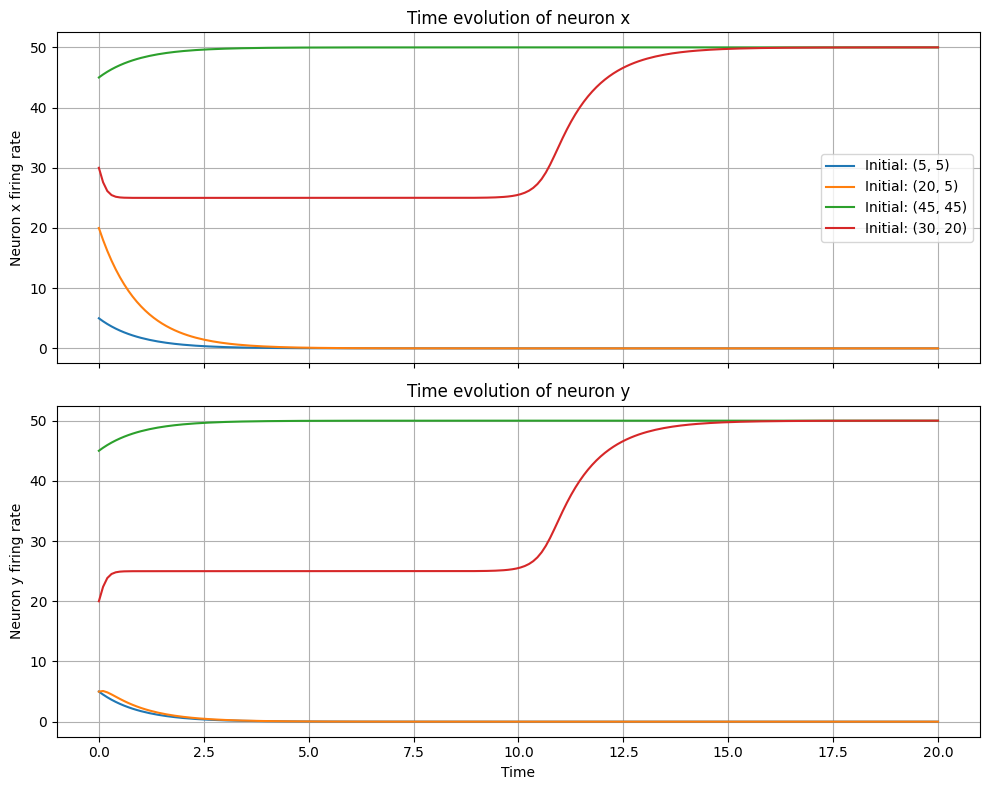

Plotted the time evolution of neuron firing rates x(t) and y(t) for different initial conditions.


In [99]:
import numpy as np
import matplotlib.pyplot as plt


"""
2.1 Plot the dynamics - Plot the evolution in time of the firing rate of 
the two neurons x(t) and y(t), for different initial conditions
"""
print("\n--- Problem 2.1: Plot the dynamics ---")

# Create network with default parameters: w1=w2=0.4, I=-10
network = MutualExcitationNetwork()

# Define different initial conditions
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [30, 20]   # Mixed initial state
]

# Plot dynamics
network.plot_dynamics(initial_states, t_max=20, dt=0.1)

print("Plotted the time evolution of neuron firing rates x(t) and y(t) for different initial conditions.")





--- Problem 2.2: Plot state space ---


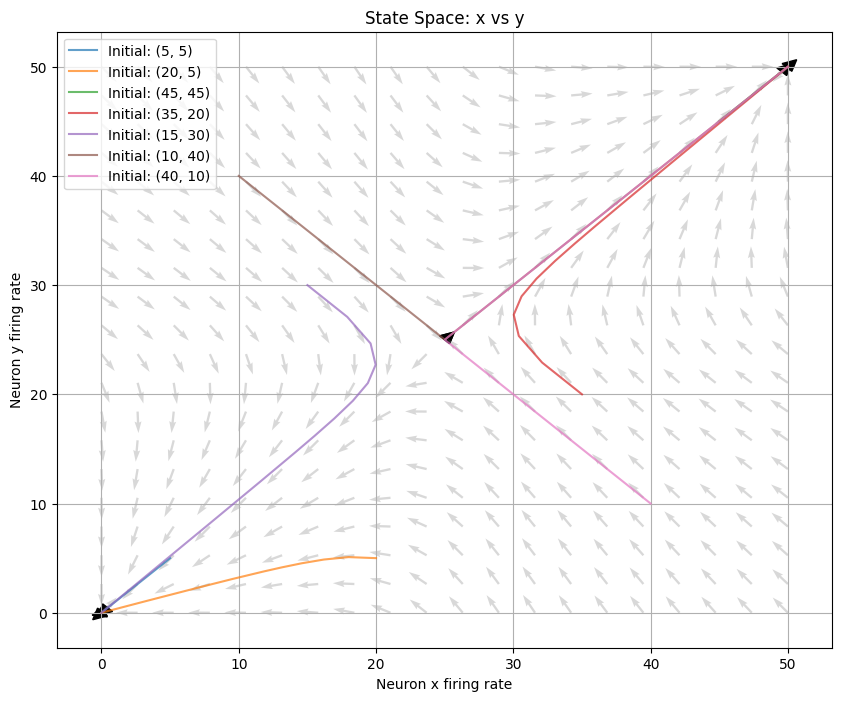

Plotted the state space trajectories for different initial conditions.


In [100]:

"""
2.2 State space - Plot the trajectories in the state space, for different initial conditions
"""
print("\n--- Problem 2.2: Plot state space ---")

# Create network
network = MutualExcitationNetwork()

# Define initial conditions for state space trajectories
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [35, 20],  # Mixed initial state
    [15, 30],  # Mixed initial state
    [10, 40],  # Low-high initial state
    [40, 10],   # High-low initial state
]

# Plot state space without nullclines
network.plot_state_space(initial_states, t_max=20, quiver=True)

print("Plotted the state space trajectories for different initial conditions.")


--- Problem 2.3: Compute and plot nullclines ---


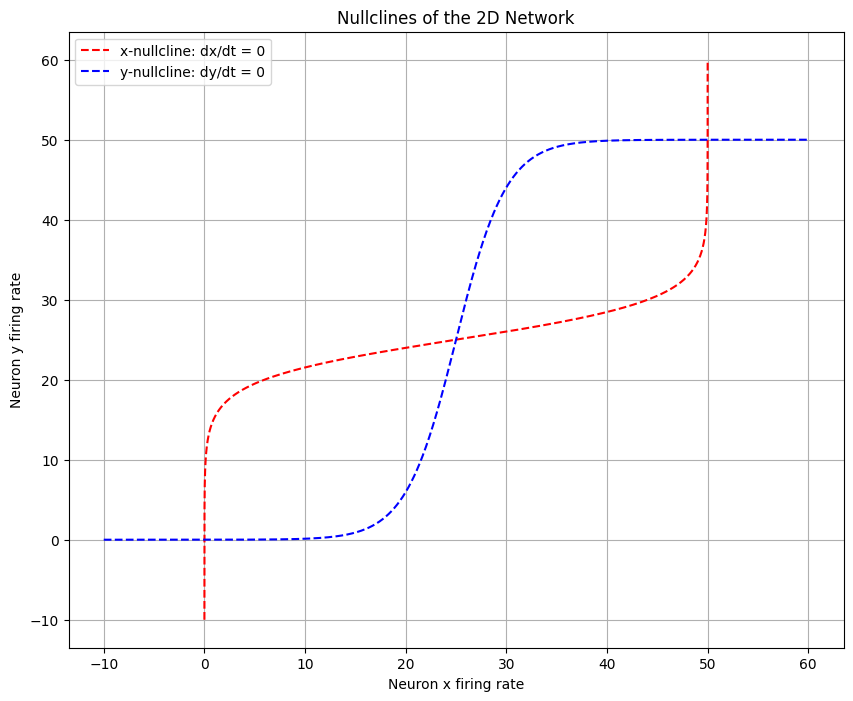

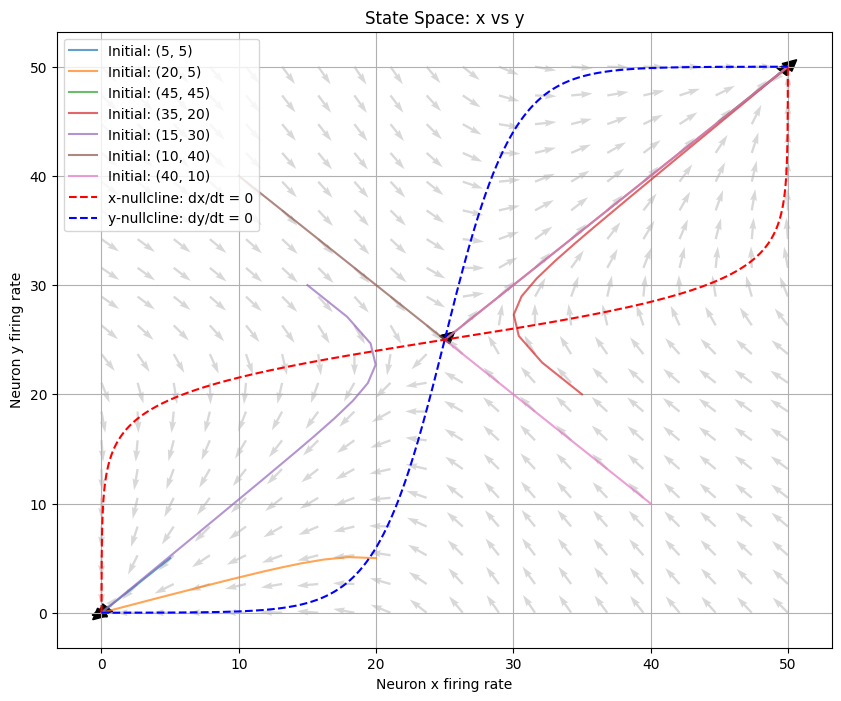

Computed and plotted the nullclines of the system.
x-nullcline equation: x = f(w2*y + I) = f(0.4*y - 10)
y-nullcline equation: y = f(w1*x + I) = f(0.4*x - 10)
The nullclines cross at the fixed points of the system.


In [101]:



"""
2.3 Nullclines - Compute the nullclines of the system and plot them
"""
print("\n--- Problem 2.3: Compute and plot nullclines ---")

# Create network
network = MutualExcitationNetwork()

# Plot nullclines
network.plot_nullclines(x_range=(-10, 60), y_range=(-10, 60))

# Plot state space with nullclines for better visualization
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [35, 20],  # Mixed initial state
    [15, 30],  # Mixed initial state
    [10, 40],  # Low-high initial state
    [40, 10],   # High-low initial state
]

network.plot_state_space(initial_states, t_max=20, 
                            show_nullclines=True, quiver=True)

# initial_states = [
#     [5, 5],    # Low-low initial state
#     [20, 5],   # Middle-low initial state
#     [45, 45],  # High-high initial state
#     [35, 20],  # Mixed initial state
#     [15, 30],  # Mixed initial state
#     [10, 40],  # Low-high initial state
#     [40, 10],   # High-low initial state
# ]

print("Computed and plotted the nullclines of the system.")
print("x-nullcline equation: x = f(w2*y + I) = f(0.4*y - 10)")
print("y-nullcline equation: y = f(w1*x + I) = f(0.4*x - 10)")
print("The nullclines cross at the fixed points of the system.")



--- Problem 2.4: Find fixed points and infer stability ---
Fixed points (where nullclines cross):
Fixed point 1: x = 0.002272, y = 0.002272
Fixed point 2: x = 49.997728, y = 49.997728
Fixed point 3: x = 25.000000, y = 25.000000


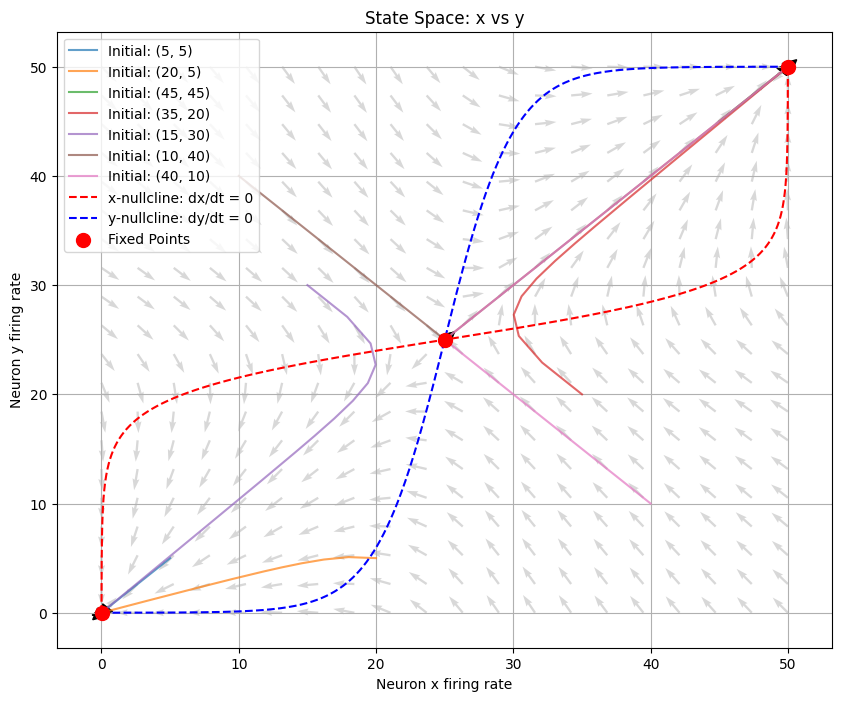


Qualitative stability analysis:
Based on the trajectories in state space:
- If trajectories converge to the fixed point, it's stable.
- If trajectories diverge from the fixed point, it's unstable.


In [102]:


"""
2.4 Fixed points - Find the fixed points and infer their stability
"""
print("\n--- Problem 2.4: Find fixed points and infer stability ---")

# Create network
network = MutualExcitationNetwork()

# Find fixed points
fixed_points = network.find_fixed_points()

print("Fixed points (where nullclines cross):")
for i, fp in enumerate(fixed_points):
    print(f"Fixed point {i+1}: x = {fp[0]:.6f}, y = {fp[1]:.6f}")

# Plot state space with nullclines and fixed points
initial_states = [
    [5, 5],    # Low-low initial state
    [20, 5],   # Middle-low initial state
    [45, 45],  # High-high initial state
    [35, 20],  # Mixed initial state
    [15, 30],  # Mixed initial state
    [10, 40],  # Low-high initial state
    [40, 10],   # High-low initial state
]


network.plot_state_space(initial_states, t_max=20, 
                            show_nullclines=True, 
                            show_fixed_points=True, quiver=True)

print("\nQualitative stability analysis:")
print("Based on the trajectories in state space:")
print("- If trajectories converge to the fixed point, it's stable.")
print("- If trajectories diverge from the fixed point, it's unstable.")



In [128]:


"""
2.5 [Extra point] Study the stability of the fixed points analytically
"""
print("\n--- Problem 2.5: Analytical stability analysis ---")

# Create network
network = MutualExcitationNetwork()

# Analyze fixed points
analysis = network.analyze_fixed_points()

print("Analytical stability analysis using Jacobian matrix:")
for i, result in enumerate(analysis):
    fp = result['fixed_point']
    # print jacobian matrix
    J = result['Jacobian']
    print(f"\nJacobian matrix at fixed point {i+1}:")
    print(f"J = \n{J}")
    print(f"Fixed point {i+1}: x = {fp[0]:.6f}, y = {fp[1]:.6f}")
    print(f"Eigenvalues: {result['eigenvalues']}")
    print(f"Trace: {result['trace']:.6f}")
    print(f"Determinant: {result['determinant']:.6f}")
    print(f"Stability: {result['stability']}")
    print(f"Classification: {result['classification']}")
    
    # Explanation
    if result['determinant'] < 0:
        print("This is a saddle point (unstable) because the determinant is negative.")
    elif result['trace'] < 0 and result['determinant'] > 0:
        if result['trace']**2 - 4*result['determinant'] < 0:
            print("This is a stable spiral because trace < 0 and trace²-4*det < 0.")
        else:
            print("This is a stable node because trace < 0 and trace²-4*det > 0.")
    else:
        if result['trace']**2 - 4*result['determinant'] < 0:
            print("This is an unstable spiral because trace > 0 and trace²-4*det < 0.")
        else:
            print("This is an unstable node because trace > 0 and trace²-4*det > 0.")



--- Problem 2.5: Analytical stability analysis ---
Analytical stability analysis using Jacobian matrix:

Jacobian matrix at fixed point 1:
J = 
[[-1.00000000e+00  9.08741553e-04]
 [ 9.08741553e-04 -1.00000000e+00]]
Fixed point 1: x = 0.002272, y = 0.002272
Eigenvalues: [-0.99909126 -1.00090874]
Trace: -2.000000
Determinant: 0.999999
Stability: Stable
Classification: Node
This is a stable node because trace < 0 and trace²-4*det > 0.

Jacobian matrix at fixed point 2:
J = 
[[-1.00000000e+00  9.08741553e-04]
 [ 9.08741553e-04 -1.00000000e+00]]
Fixed point 2: x = 49.997728, y = 49.997728
Eigenvalues: [-0.99909126 -1.00090874]
Trace: -2.000000
Determinant: 0.999999
Stability: Stable
Classification: Node
This is a stable node because trace < 0 and trace²-4*det > 0.

Jacobian matrix at fixed point 3:
J = 
[[-1.  5.]
 [ 5. -1.]]
Fixed point 3: x = 25.000000, y = 25.000000
Eigenvalues: [ 4. -6.]
Trace: -2.000000
Determinant: -24.000000
Stability: Unstable
Classification: Saddle point
This is a

/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_6469/539654947.py:33: RuntimeWarning: overflow encountered in exp
  return 50 / (1 + np.exp(-s))


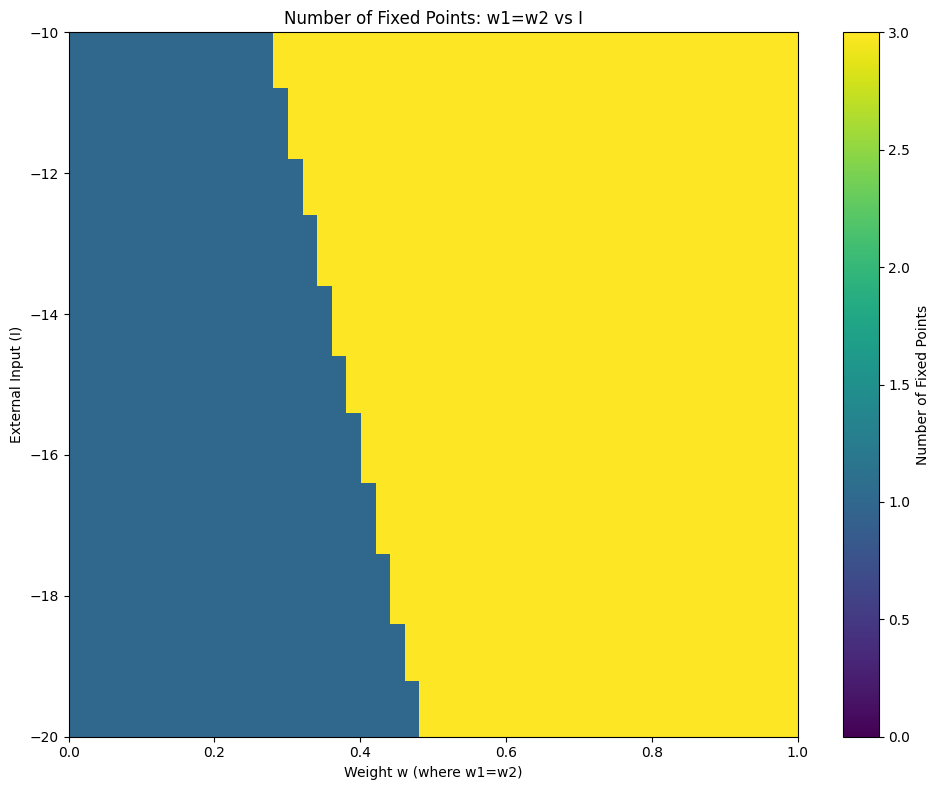

Analysis of weight bifurcation matrices:
- The heatmap shows the number of fixed points for each (weight, I) combination.
- Regions with different colors indicate transitions in system behavior.
- Increasing weights generally leads to more complex dynamics (multiple fixed points).
- These plots help identify parameter regions with qualitatively different behaviors.
- We're using the simplification that w1=w2, so both synaptic strengths are equal.


In [112]:
"""
2.6 Bifurcation diagram - Show how the number of solutions changes with input current
"""

# Create network
network = MutualExcitationNetwork()

# Plot weight bifurcation matrices with moderate resolution
# Use fewer steps for faster computation in this demonstration
network.plot_weight_bifurcation_matrices(
    I_range=(-20, -10),
    I_steps=50,       # Increment of 0.1 for I
    w_range=(0, 1),
    w_steps=50,      # Increment of 0.05 for w (where w1=w2)
)

print("Analysis of weight bifurcation matrices:")
print("- The heatmap shows the number of fixed points for each (weight, I) combination.")
print("- Regions with different colors indicate transitions in system behavior.")
print("- Increasing weights generally leads to more complex dynamics (multiple fixed points).")
print("- These plots help identify parameter regions with qualitatively different behaviors.")
print("- We're using the simplification that w1=w2, so both synaptic strengths are equal.")

Plotting nullcline evolution across input current range...


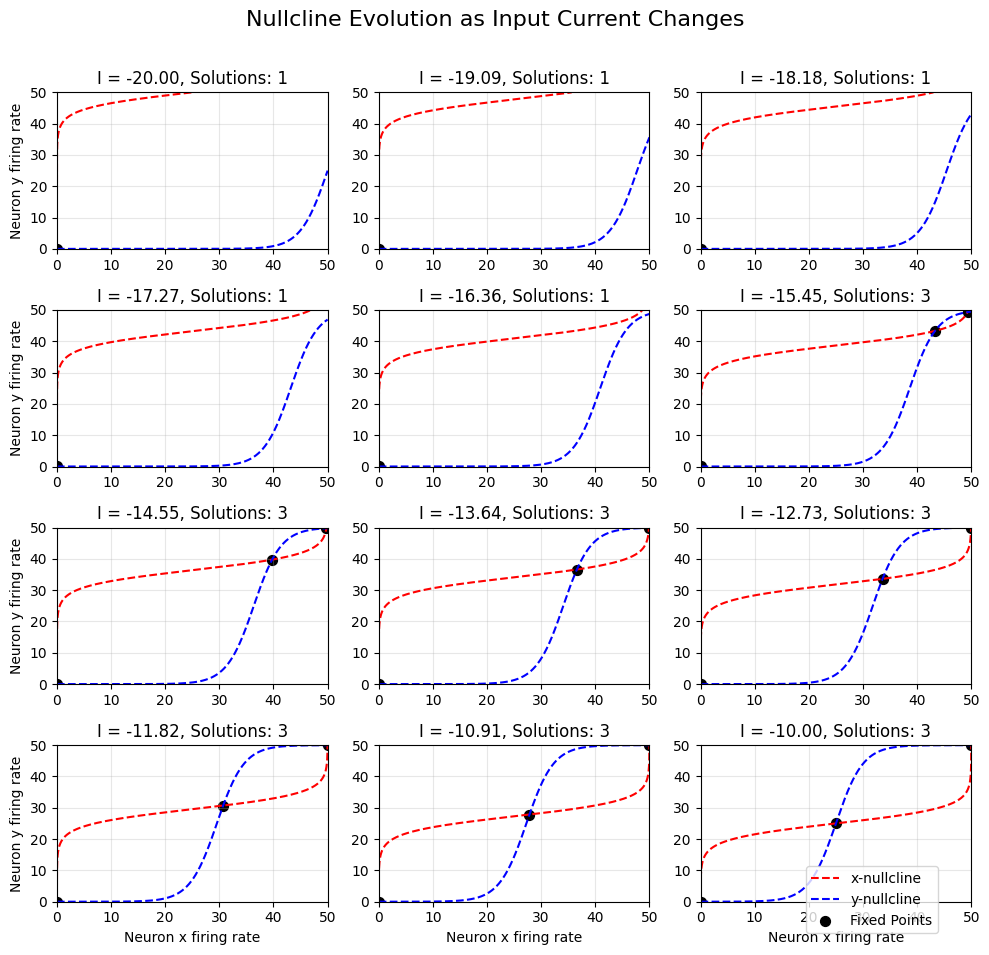

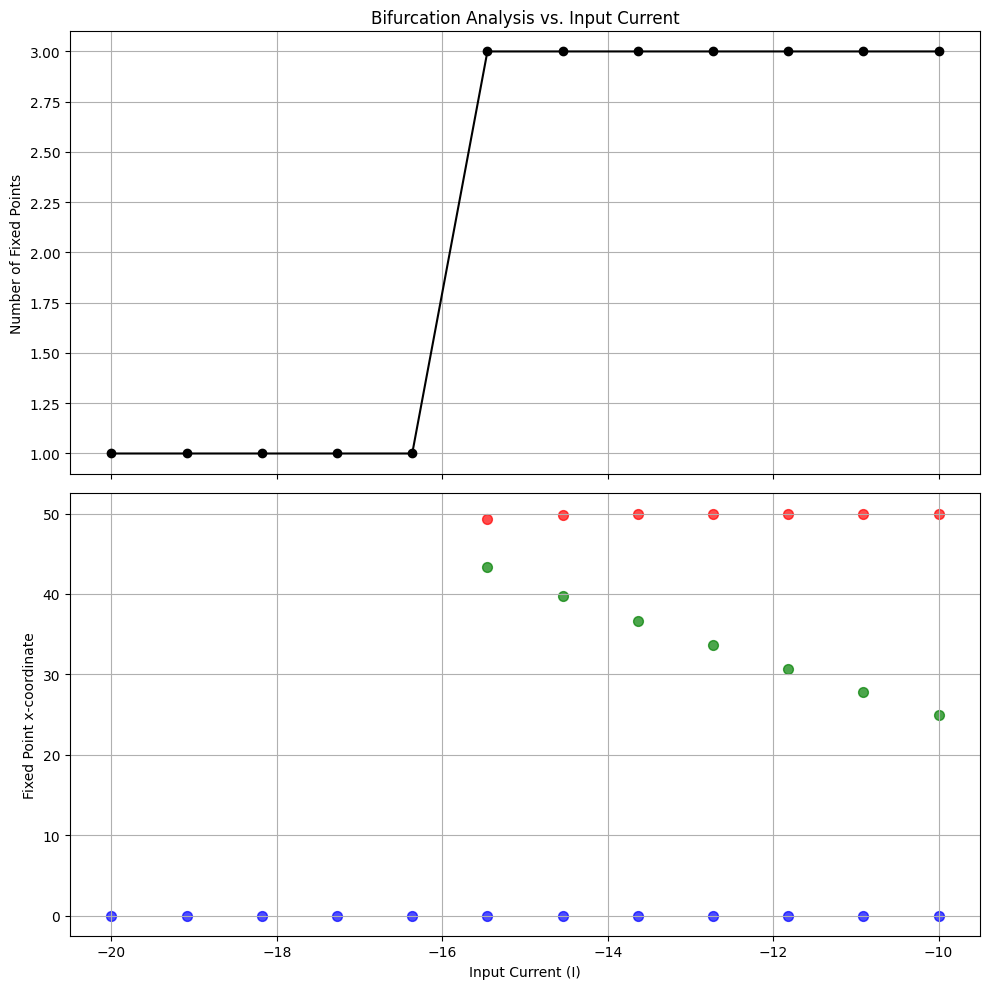


Found 2 regimes across I = [-20, -10]:
Regime 1: I ∈ [-20.00, -16.36], 1 fixed point(s)
Regime 2: I ∈ [-15.45, -10.00], 3 fixed point(s)

Performing detailed bifurcation analysis...
Scanning input current range for bifurcations...
Processing I = -20.00 (0/101)
Processing I = -19.00 (10/101)
Processing I = -18.00 (20/101)
Processing I = -17.00 (30/101)
Processing I = -16.00 (40/101)
Processing I = -15.00 (50/101)
Processing I = -14.00 (60/101)
Processing I = -13.00 (70/101)
Processing I = -12.00 (80/101)
Processing I = -11.00 (90/101)
Processing I = -10.00 (100/101)


/var/folders/mx/zr8t6k3s0xz2w8s2hl4llfj40000gn/T/ipykernel_6469/3716815416.py:33: RuntimeWarning: overflow encountered in exp
  return 50 / (1 + np.exp(-s))



Found 2 distinct regimes across I = [-20, -10]:
Regime 1: I ∈ [-20.000, -16.100]
   1 total fixed point(s), 1 stable
Regime 2: I ∈ [-16.000, -10.000]
   3 total fixed point(s), 2 stable

Bifurcation points (where number of fixed points changes):
Transition 1 at I ≈ -16.050: 1 → 3 fixed points

Conclusion:
The analysis shows how the system's behavior changes as I varies from -20 to -10:
1. The number of fixed points changes at specific bifurcation points
2. The shape and intersection of nullclines varies with input current
3. Different regimes (parameter regions with qualitatively different behaviors) exist
4. These regimes help us understand the system's dynamic behavior in different conditions


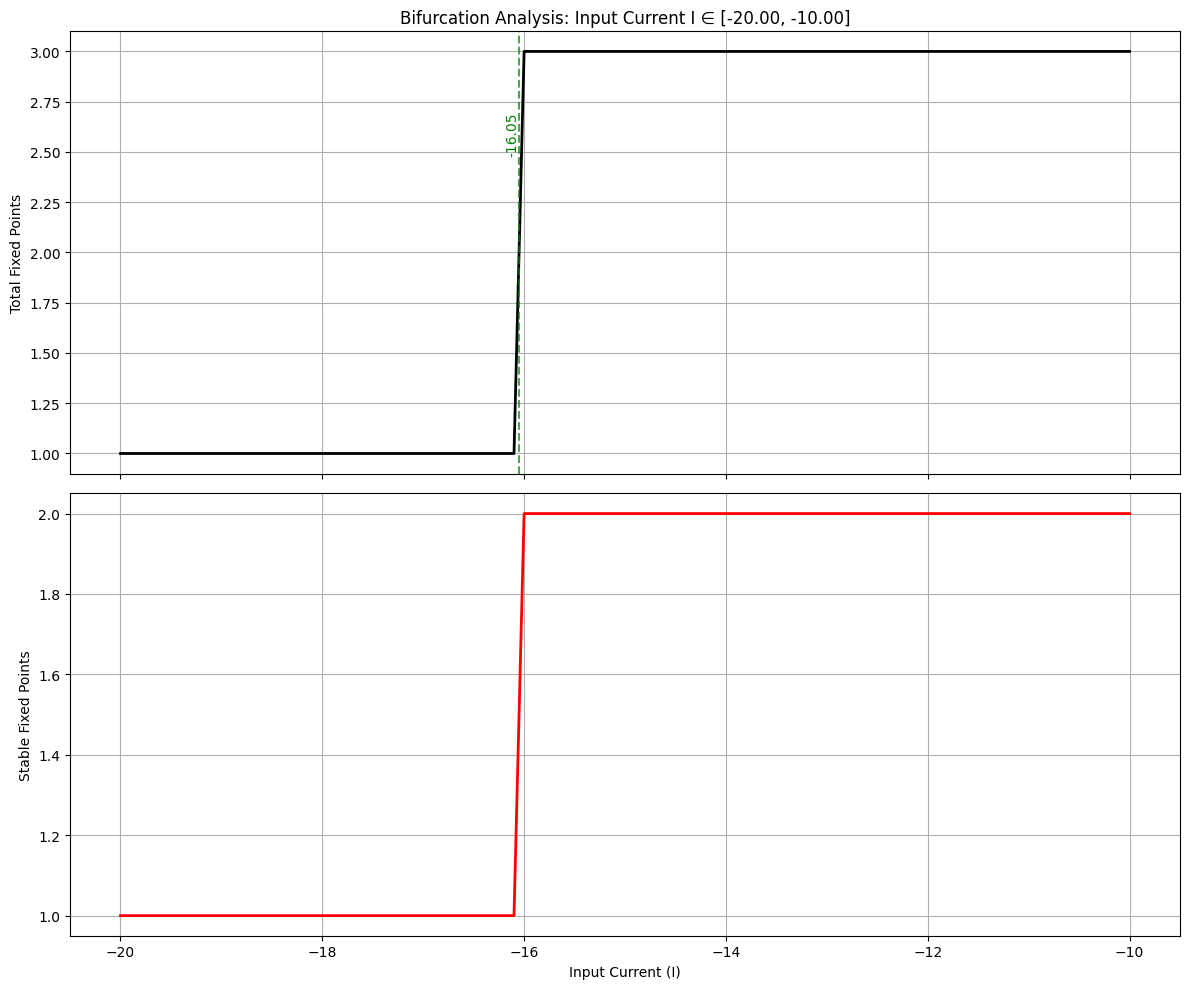

In [124]:
"""
2.6 Bifurcation diagram - Show how the number of solutions changes with input current
"""

# Create network
network = MutualExcitationNetwork(w1=0.4, w2=0.4)

# Plot nullcline evolution with 9 representative values of I
print("Plotting nullcline evolution across input current range...")
regimes = network.plot_nullcline_evolution(I_range=(-20, -10), I_steps=12)

# For more detailed regime analysis, use the second function
print("\nPerforming detailed bifurcation analysis...")
regimes_detailed, transitions = network.analyze_input_current_regimes(I_range=(-20, -10), I_steps=101)

print("\nConclusion:")
print("The analysis shows how the system's behavior changes as I varies from -20 to -10:")
print("1. The number of fixed points changes at specific bifurcation points")
print("2. The shape and intersection of nullclines varies with input current")
print("3. Different regimes (parameter regions with qualitatively different behaviors) exist")
print("4. These regimes help us understand the system's dynamic behavior in different conditions")